#### MNIST

# 🧾 Importing Libraries

In this step, we import all the required Python libraries for building and training our Convolutional Neural Network (CNN) on the MNIST dataset.

- **numpy** → numerical operations  
- **tensorflow / keras** → deep learning framework  
- **matplotlib** → for visualizing data and training results  
- **ImageDataGenerator** → for optional data augmentation (rotation, zoom, shifts, etc.)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from PIL import Image, ImageOps
from tensorflow.keras.models import load_model
import gradio as gr
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 🔄 Data Preprocessing (MNIST)

We prepare the **MNIST dataset** (handwritten digits 0–9) for training our CNN:

- **Load dataset** → 28×28 grayscale images.  
- **Normalize pixel values** → scale from `[0, 255]` to `[0, 1]` for faster and more stable training.  
- **Reshape data** → CNN expects `(height, width, channels)` format, so we reshape to `(28, 28, 1)`.  
- **Data Augmentation** → random transformations (rotation, shifts, zoom) are applied using `ImageDataGenerator` to make the model more robust and reduce overfitting.


In [ ]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values (0–16 → 0–1)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Reshape for CNN (samples, 28, 28, 1) since MNIST images are 28x28
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# MNIST Data Visualization

We start by visualizing some sample digits and checking the distribution of labels in the dataset.


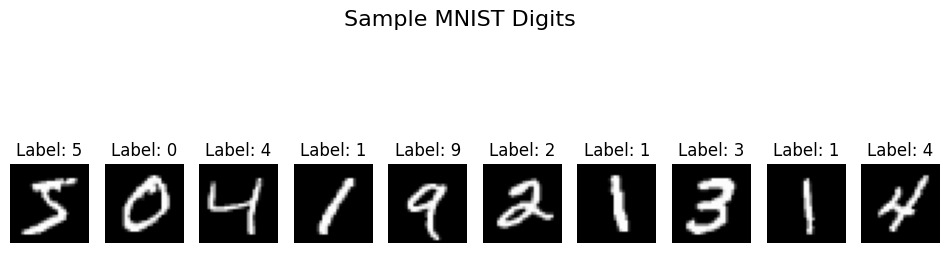

In [22]:
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.suptitle("Sample MNIST Digits", fontsize=16)
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27444\1154193079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="tab10")


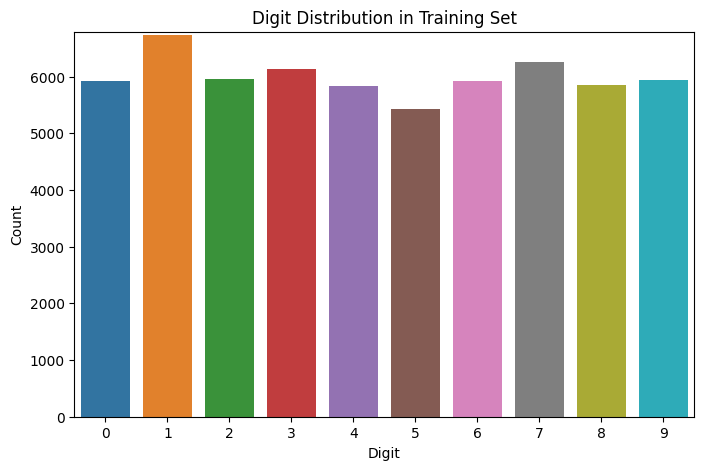

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette="tab10")
plt.title("Digit Distribution in Training Set")
plt.ylim(0, np.max(np.bincount(y_train)) + 50)  # dynamic y-limit
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

### Building the CNN Model

Now we will define our Convolutional Neural Network (CNN) for handwritten digit recognition on the MNIST dataset.

**Architecture:**
1. **Conv2D Layer (32 filters, 3×3 kernel, ReLU activation):** Detects simple patterns like edges and lines.  
2. **MaxPooling2D (2×2):** Reduces spatial size (downsampling) while keeping important features.  
3. **Conv2D Layer (64 filters, 3×3, ReLU):** Learns more complex patterns.  
4. **MaxPooling2D (2×2):** Further downsampling.  
5. **Flatten:** Converts 2D feature maps into 1D vector to connect to Dense layers.  
6. **Dense Layer (128 neurons, ReLU):** Fully connected layer for high-level reasoning.  
7. **Output Layer (10 neurons, Softmax):** 10 classes (digits 0–9).  

We use:
- **Optimizer:** Adam (efficient gradient descent)  
- **Loss Function:** Sparse Categorical Crossentropy (good for integer labels)  
- **Metric:** Accuracy  


In [16]:
# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for digits
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show summary
model.summary()
# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test, y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9182 - loss: 0.2596 - val_accuracy: 0.9841 - val_loss: 0.0482
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9708 - loss: 0.0894 - val_accuracy: 0.9884 - val_loss: 0.0336
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9791 - loss: 0.0673 - val_accuracy: 0.9849 - val_loss: 0.0481
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9835 - loss: 0.0543 - val_accuracy: 0.9899 - val_loss: 0.0345
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9847 - loss: 0.0491 - val_accuracy: 0.9888 - val_loss: 0.0359
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9865 - loss: 0.0430 - val_accuracy: 0.9937 - val_loss: 0.0206
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9880 - loss: 0.0388 - val_accuracy: 0.9934 - val_loss: 0.0232
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9884 - loss: 0.0378 - va

### 📊 Model Evaluation

After training, we evaluate the model on the **test dataset** to measure its performance on unseen data.  
We will check:
- **Test Accuracy** → how well the model predicts digits it hasn’t seen before.  
- **Classification Report** → precision, recall, F1-score for each digit (0–9).  
- **Confusion Matrix** → shows where the model predicts correctly and where it makes mistakes.


✅ Test Accuracy: 0.9916
✅ Test Loss: 0.0280
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📌 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.97      1.00      0.98      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.97      0.98       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



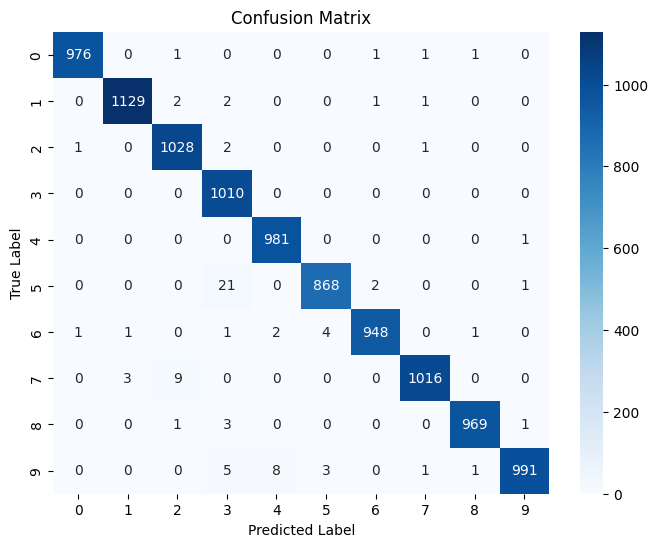

In [ ]:


# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print("\n📌 Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 💾 Saving the Model

After training, we save our CNN model as `digits_model.h5`.  
This file contains:
- The model architecture.  
- All the learned weights.  
- Training configuration (optimizer, loss).  

Later, we can load this file directly for prediction or deployment (e.g., in Gradio) without retraining the model.


In [18]:
model.save("digits_model.h5")

### 🌐 Gradio Deployment

We deploy our trained CNN model using **Gradio**:

- Load the saved model (`digits_model.h5`).  
- User draws a digit on the **sketchpad**.  
- Image is preprocessed (grayscale, inverted, resized to 28×28, normalized).  
- Model predicts the digit (0–9).  
- Result is shown instantly in the browser.  


In [ ]:

#  Load the model
model_path = "digits_model.h5"
model = load_model(model_path)


# Function to predict the digit
def predict_digit(sketchpad):
    if sketchpad is not None:
        # Extract sketchpad data and convert it to a PIL Image
        image_data = sketchpad['composite']
        pil_image = Image.fromarray(image_data)

        # Fill transparent background with white
        if pil_image.mode == "RGBA":  # If the image has an alpha channel
            white_background = Image.new("RGBA", pil_image.size, (255, 255, 255, 255))
            pil_image = Image.alpha_composite(white_background, pil_image)
            pil_image = pil_image.convert("RGB")  # Remove the alpha channel

        # Convert to grayscale
        grayscale_image = pil_image.convert("L")
        img = ImageOps.invert(grayscale_image)       # Invert colors
        img = img.resize((28, 28))       # Resize to 28x28
        img = np.array(img) / 255.0      # Normalize pixel values to [0, 1]
        img = img.reshape(-1, 28, 28, 1)  # Reshape to match model input

        # Get model prediction
        pred = model.predict(img)
        predicted_digit = np.argmax(pred)  # Get the digit with the highest probability

        return f"Predicted Digit: {predicted_digit}"


# Create the Gradio interface
gr.Interface(
    fn=predict_digit,
    inputs="sketchpad",
    outputs="text"
).launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Using existing dataset file at: .gradio\flagged\dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Keyboard interruption in main thread... closing server.
